# Model Training and Storing

In [88]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [89]:
# Loading the MNIST dataset
mnist = tf.keras.datasets.mnist

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# x_train and x_test contain grayscale 28*28 images
# y_train and y_test contain the actual (ground truth) number (digit) that is in the picture

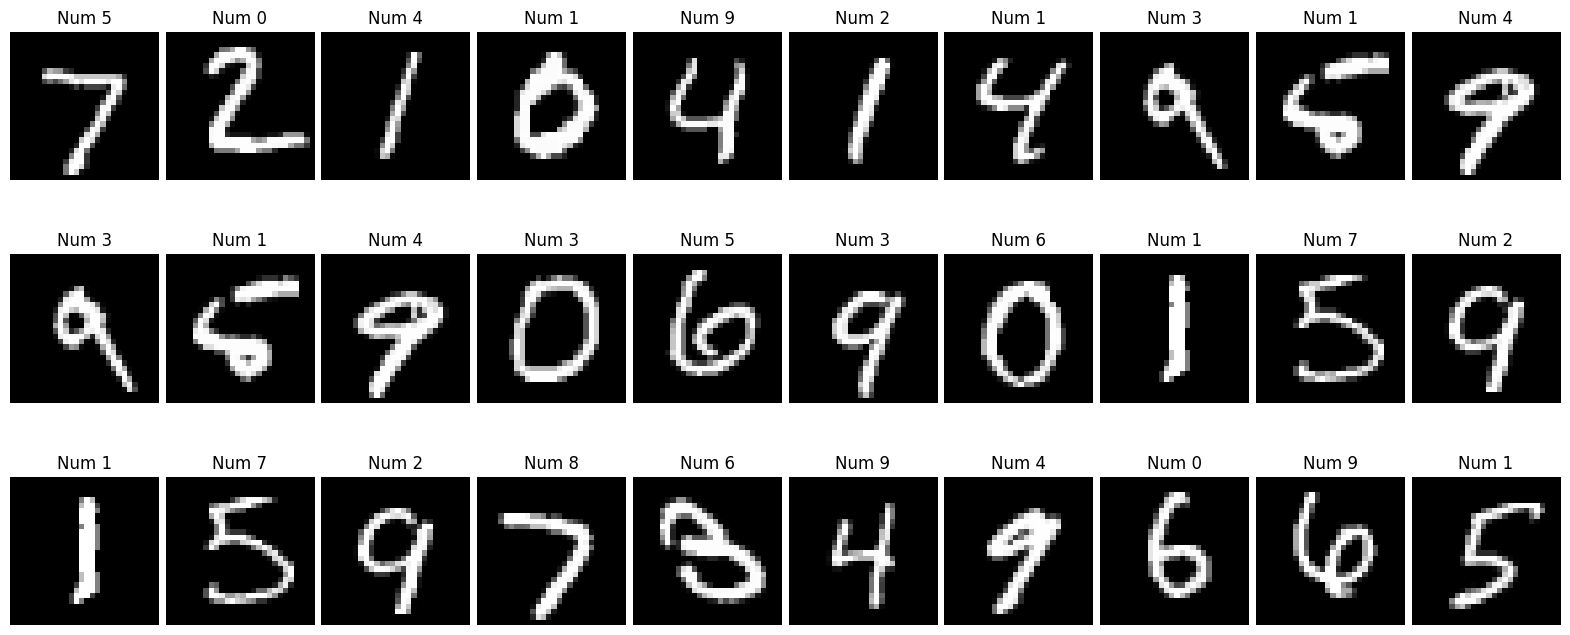

In [90]:
# Let's visualize some of these images
import matplotlib.pyplot as plt

start_index = 0

num_rows, num_cols = 3, 10
f, ax = plt.subplots(num_rows, num_cols, figsize=(20,8),
                     gridspec_kw={'wspace':0.05, 'hspace':0.3})

for r in range(num_rows):
    for c in range(num_cols):
        image_index = start_index + r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(x_test[image_index], cmap='gray')
        ax[r,c].set_title('Num %d' % y_train[image_index])
        
plt.subplots_adjust(hspace=2)  # make adjustments so that titles are shown correctly
plt.show()

In [91]:
# We are now ready to train a model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit model using training data
model.fit(x_train, y_train, epochs=5)

2022-11-25 21:56:35.222524: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2182 - accuracy: 0.9359
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0963 - accuracy: 0.9708
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0677 - accuracy: 0.9786
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0533 - accuracy: 0.9827
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0436 - accuracy: 0.9857


In [93]:
# Store model weights, which we later load in model script
model.save_weights('./binaries/tf_mnist_cp.h5')

# Store model directly to an h5 file
model.save("./binaries/mnist.h5")

In [94]:
# To test that the saved model can be loaded and used for predictions, we proceed as follows:

# Either load the saved model directly from the .h5 file:
model_from_saved_model = tf.keras.models.load_model('./binaries/mnist.h5')
print("Sample prediction: ", model_from_saved_model.predict(x_test[:1]))

# Or load the weights from the .h5 file:
model_from_weighst = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
)

model_from_weighst.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_from_weighst.load_weights('./binaries/tf_mnist_cp.h5')
print("Sample Prediction: ", model_from_saved_model.predict(x_test[:1]))


Sample prediction:  [[6.0958065e-08 8.8407477e-09 1.6787100e-06 5.4657785e-06 3.2309976e-13
  2.1413317e-08 2.8739280e-13 9.9999177e-01 2.1608894e-07 7.5952039e-07]]
Sample Prediction:  [[6.0958065e-08 8.8407477e-09 1.6787100e-06 5.4657785e-06 3.2309976e-13
  2.1413317e-08 2.8739280e-13 9.9999177e-01 2.1608894e-07 7.5952039e-07]]


# Input/Output Schema

In [95]:
# input_schema.avsc

input_schema = {
    "type": {
        "type": "array",
        "items": {
            "type": "array",
            "items": "float"
        }
    }
}


output_schema = {
    "name": "output_schema",
    "type": "record",
    "fields": [
        {
            "name": "predicted_probs",
            "type": {
                "type": "array",
                "items": "float"
            }
        },
        {
            "name": "score",
            "type": "int"
        }
    ]
}

with open("input_schema.avsc", "w") as f:
    json.dump(input_schema, f)
f.close()

with open("output_schema.avsc", "w") as f:
    json.dump(output_schema, f)
f.close()

# Model Script

In [96]:
import tensorflow as tf
import numpy as np


def init():
    """
    A function to load pre-trained model into a global variable
    """
    
    global model
    # Loading model from trained artifact    
    model = tf.keras.models.load_model('./binaries/mnist.h5')


def predict(pixel_array: np.ndarray) -> dict:
    """
    A function to predict probabilities and assign digit to input image

    Args:
        pixel_array (np.ndarray): 28x28 numpy array (or List[List]), representing pixel
            values of a handwritten digit.
    
    Returns:
        (dict): Digit probabilities and most likely digit.
    """

    # Compute 10 probabilities, 1 for each possible digit
    predicted_probs = np.round(
        model.predict(np.array([pixel_array])).tolist()[0], 5
    )
    
    # Add the best possible matching digit to the output
    score = np.argmax(predicted_probs)
    
    return {
        "predicted_probs": predicted_probs.tolist(),
        "score": int(score)
    }


In [97]:
# Let's test the model by running the begin() function to load the saved model first, then calling
# the action function on a sample input image
init()

sample_score = predict(
    [
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.0117647059,0.0705882353,0.0705882353,0.0705882353,0.4941176471,0.5333333333,0.6862745098,0.1019607843,0.6509803922,1.0,0.968627451,0.4980392157,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.1176470588,0.1411764706,0.368627451,0.6039215686,0.6666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.8823529412,0.6745098039,0.9921568627,0.9490196078,0.7647058824,0.2509803922,0,0,0,0],
        [0,0,0,0,0,0,0,0.1921568627,0.9333333333,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9843137255,0.3647058824,0.3215686275,0.3215686275,0.2196078431,0.1529411765,0,0,0,0,0],
        [0,0,0,0,0,0,0,0.0705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.7137254902,0.968627451,0.9450980392,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.3137254902,0.6117647059,0.4196078431,0.9921568627,0.9921568627,0.8039215686,0.0431372549,0,0.168627451,0.6039215686,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0.0549019608,0.0039215686,0.6039215686,0.9921568627,0.3529411765,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0.5450980392,0.9921568627,0.7450980392,0.0078431373,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0.0431372549,0.7450980392,0.9921568627,0.2745098039,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.137254902,0.9450980392,0.8823529412,0.6274509804,0.4235294118,0.0039215686,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0.3176470588,0.9411764706,0.9921568627,0.9921568627,0.4666666667,0.0980392157,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1764705882,0.7294117647,0.9921568627,0.9921568627,0.5882352941,0.1058823529,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.062745098,0.3647058824,0.9882352941,0.9921568627,0.7333333333,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9764705882,0.9921568627,0.9764705882,0.2509803922,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1803921569,0.5098039216,0.7176470588,0.9921568627,0.9921568627,0.8117647059,0.0078431373,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0.1529411765,0.5803921569,0.8980392157,0.9921568627,0.9921568627,0.9921568627,0.9803921569,0.7137254902,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0.0941176471,0.4470588235,0.8666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7882352941,0.3058823529,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0.0901960784,0.2588235294,0.8352941176,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.3176470588,0.0078431373,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0.0705882353,0.6705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7647058824,0.3137254902,0.0352941176,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0.2156862745,0.6745098039,0.8862745098,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9568627451,0.5215686275,0.0431372549,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0.5333333333,0.9921568627,0.9921568627,0.9921568627,0.831372549,0.5294117647,0.5176470588,0.062745098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    ]
)

In [98]:
# Here's the output dictionary
sample_score

{'predicted_probs': [0.0, 0.0, 0.0, 0.00216, 0.0, 0.99784, 0.0, 0.0, 0.0, 0.0],
 'score': 5}

In [99]:
# predicting on sample from train dataset directly
predict(x_train[0])

{'predicted_probs': [0.0, 0.0, 0.0, 0.00216, 0.0, 0.99784, 0.0, 0.0, 0.0, 0.0],
 'score': 5}

In [100]:
# Predicitng on a file of pixel arrays
with open("./data/sample_input.json", "r") as input:
    with open("./data/sample_output.json", "w") as output:
        for record in input:
            pixel_array = json.loads(record)["pixel_array"]
            model_output = predict(pixel_array)
            output.write(json.dumps(model_output))
            output.write("\n")